# Domain Listings Preprocessing

This notebook performs preprocessing on both live and wayback scraped listings from the Domain website. 

## Overview

The preprocessing pipeline includes:
1. **Live Listings Processing**: Handles current listings with property features parsing
2. **Wayback Listings Processing**: Handles historical listings from archived data
3. **Data Combination**: Merges both datasets and performs some preliminary EDA and stratified sampling
4. **Geospatial Setup**: Prepares data for coordinate fetching and isochrone generation

## Property Type Mapping

Permitted property types are defined as "renter friendly types":

**House types:**
- House, Townhouse, Villa, New House & Land, Semi-Detached, Terrace, Duplex

**Flat types:**
- Apartment / Unit / Flat, Studio, New Apartments / Off the Plan, Penthouse

**Excluded types:**
- Vacant Land, Carspace, Block of Units, Acreage / Semi-rural, Rural


In [55]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import pandas as pd
import glob
import os
import sys
from pathlib import Path
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np


# Add project root to Python path
current_dir = Path().resolve()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
elif current_dir.name == 'project2':
    project_root = current_dir
else:
    # If we're in the parent directory, look for project2
    project_root = current_dir / 'project2'

sys.path.insert(0, str(project_root))
print(f"Project root: {project_root}")

from utils.preprocess import PreprocessUtils
from utils.geo import GeoUtils

# Initialize the preprocessor and geo utils
preprocessor = PreprocessUtils()
geo_utils = GeoUtils()

pd.set_option("display.max_rows", None)  # Show all rows, default is 10
pd.set_option("display.max_columns", None)  # Show all columns, default is 20


Project root: /Users/jackshee/University/MAST30034 Applied Data Science/project2
OpenRouteService client initialized successfully.


## 1. Live Listings Preprocessing

Process the current live listings from Domain website. These listings have individual property pages with detailed features.


In [57]:
# Load live listings data
df_live = pd.read_csv("../data/landing/domain/live/rental_listings_2025_09.csv")

print(f"Original live listings shape: {df_live.shape}")

# Preprocess live listings using the utility function
df_live_processed = preprocessor.preprocess_live_listings(df_live)

print(f"Processed live listings shape: {df_live_processed.shape}")
print(f"Unique suburbs in live listings: {df_live_processed['suburb'].nunique()}")
print(f"Property type distribution:")
print(df_live_processed['house_flat_other'].value_counts())


Original live listings shape: (14146, 47)
Property type: apartment / unit / flat, bedrooms imputed with 2
Property type: house, bedrooms imputed with 4
Property type: studio, bedrooms imputed with 1
Property type: apartment / unit / flat, bathrooms imputed with 1
Property type: house, bathrooms imputed with 2
Property type: townhouse, car_spaces imputed with 2
Property type: apartment / unit / flat, car_spaces imputed with 1
Property type: house, car_spaces imputed with 2
Property type: studio, car_spaces imputed with 1
Property type: villa, car_spaces imputed with 1
Property type: terrace, car_spaces imputed with 2
Property type: new apartments / off the plan, car_spaces imputed with 1
Property type: semi-detached, car_spaces imputed with 1
Processed live listings shape: (12650, 49)
Unique suburbs in live listings: 245
Property type distribution:
house_flat_other
house      7577
unknown    4860
flat        213
Name: count, dtype: int64


/Users/jackshee/University/MAST30034 Applied Data Science/project2/utils/preprocess.py:1119: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["appointment_only"] = df["appointment_only"].fillna(


In [58]:
# Select relevant columns for live listings
relevant_columns = [
    'property_id','rental_price', 
    'suburb', 'postcode', 'property_type', 'year', 'quarter',
    'bedrooms', 'bathrooms', 'car_spaces',
    'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus',
    'agency_name', 'appointment_only', 'avg_days_on_market',
    'description', 'family_percentage',
    'first_listed_date',
    'latitude', 'longitude', 'listing_status', 'long_term_resident', 
    'median_rent_price', 'median_sold_price', 'number_sold',
    'renter_percentage', 'single_percentage'
]

# Keep only columns that exist in the dataframe
available_columns = [col for col in relevant_columns if col in df_live_processed.columns]
df_live_final = df_live_processed[available_columns]

# Remove any remaining null values
df_live_final = df_live_final.dropna()

print(f"Final live listings shape: {df_live_final.shape}")
print(f"Columns: {list(df_live_final.columns)}")

# Save processed live listings
df_live_final.to_csv("../data/raw/domain/live_listings.csv", index=False)
print("✓ Saved live listings to data/raw/domain/live_listings.csv")


Final live listings shape: (12649, 29)
Columns: ['property_id', 'rental_price', 'suburb', 'postcode', 'property_type', 'year', 'quarter', 'bedrooms', 'bathrooms', 'car_spaces', 'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus', 'agency_name', 'appointment_only', 'avg_days_on_market', 'description', 'family_percentage', 'first_listed_date', 'latitude', 'longitude', 'listing_status', 'long_term_resident', 'median_rent_price', 'median_sold_price', 'number_sold', 'renter_percentage', 'single_percentage']
✓ Saved live listings to data/raw/domain/live_listings.csv


## 2. Wayback Listings Preprocessing

Process historical listings from Wayback Machine archives. These are summary listings without individual property pages.


In [59]:
# Define the path to the domain folder
domain_path = "../data/landing/domain/wayback"

# Get all CSV files except rental_listings_2025_09.csv (live listings)
csv_files = glob.glob(os.path.join(domain_path, "rental_listings_*.csv"))
csv_files = [f for f in csv_files if "rental_listings_2025_09.csv" not in f]

print(f"Found {len(csv_files)} wayback files to process:")
for f in sorted(csv_files):
    print(f"  - {os.path.basename(f)}")


Found 14 wayback files to process:
  - rental_listings_2022_03.csv
  - rental_listings_2022_06.csv
  - rental_listings_2022_09.csv
  - rental_listings_2022_12.csv
  - rental_listings_2023_03.csv
  - rental_listings_2023_06.csv
  - rental_listings_2023_09.csv
  - rental_listings_2023_12.csv
  - rental_listings_2024_03.csv
  - rental_listings_2024_06.csv
  - rental_listings_2024_09.csv
  - rental_listings_2024_12.csv
  - rental_listings_2025_03.csv
  - rental_listings_2025_06.csv


In [60]:
# Read all CSV files and add year and quarter columns
dataframes = []

for csv_file in sorted(csv_files):
    # Extract filename without extension
    filename = os.path.basename(csv_file)
    # Parse filename: rental_listings_YYYY_MM.csv
    parts = filename.replace('.csv', '').split('_')
    year = parts[2]
    month = parts[3]
    
    # Map month to quarter
    month_to_quarter = {
        '03': 1,
        '06': 2,
        '09': 3,
        '12': 4
    }
    quarter = month_to_quarter.get(month, 'Unknown')
    
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Add year and quarter columns
    df['year'] = int(year)
    df['quarter'] = quarter
    
    dataframes.append(df)
    print(f"Loaded {filename}: {len(df)} rows, Year={year}, Quarter={quarter}")

print(f"\nTotal dataframes loaded: {len(dataframes)}")


Loaded rental_listings_2022_03.csv: 20 rows, Year=2022, Quarter=1
Loaded rental_listings_2022_06.csv: 3047 rows, Year=2022, Quarter=2
Loaded rental_listings_2022_09.csv: 710 rows, Year=2022, Quarter=3
Loaded rental_listings_2022_12.csv: 23 rows, Year=2022, Quarter=4
Loaded rental_listings_2023_03.csv: 123 rows, Year=2023, Quarter=1
Loaded rental_listings_2023_06.csv: 98 rows, Year=2023, Quarter=2
Loaded rental_listings_2023_09.csv: 20 rows, Year=2023, Quarter=3
Loaded rental_listings_2023_12.csv: 179 rows, Year=2023, Quarter=4
Loaded rental_listings_2024_03.csv: 1372 rows, Year=2024, Quarter=1
Loaded rental_listings_2024_06.csv: 1786 rows, Year=2024, Quarter=2
Loaded rental_listings_2024_09.csv: 1460 rows, Year=2024, Quarter=3
Loaded rental_listings_2024_12.csv: 1562 rows, Year=2024, Quarter=4
Loaded rental_listings_2025_03.csv: 3340 rows, Year=2025, Quarter=1
Loaded rental_listings_2025_06.csv: 3382 rows, Year=2025, Quarter=2

Total dataframes loaded: 14


In [61]:
# Preprocess wayback listings using the utility function
df_wayback_processed = preprocessor.preprocess_wayback_listings(dataframes, geo_utils)

print(f"Processed wayback listings shape: {df_wayback_processed.shape}")
print(f"Unique suburbs in wayback listings: {df_wayback_processed['suburb'].nunique()}")

# Save processed wayback listings
df_wayback_processed.to_csv("../data/raw/domain/wayback_listings.csv", index=False)
print("✓ Saved wayback listings to data/raw/domain/wayback_listings.csv")


Property type: Apartment / Unit / Flat, bedrooms imputed with 2
Property type: Townhouse, bedrooms imputed with 3
Property type: House, bedrooms imputed with 3
Property type: Studio, bedrooms imputed with 1
Property type: Duplex, bedrooms imputed with 2
Property type: Vacant land, bedrooms imputed with 4
Property type: Farm, bedrooms imputed with <NA>
Property type: Apartment / Unit / Flat, bathrooms imputed with 1
Property type: Townhouse, bathrooms imputed with 2
Property type: House, bathrooms imputed with 2
Property type: Studio, bathrooms imputed with 1
Property type: Vacant land, bathrooms imputed with 2
Property type: Farm, bathrooms imputed with <NA>
Property type: Apartment / Unit / Flat, car_spaces imputed with 1
Property type: Townhouse, car_spaces imputed with 2
Property type: House, car_spaces imputed with 2
Property type: Studio, car_spaces imputed with 1
Property type: New Apartments / Off the Plan, car_spaces imputed with 1
Property type: Duplex, car_spaces imputed with

### Address Extraction and Geocoding

The `preprocess_wayback_listings` function has already handled the initial preprocessing steps including:

- **Address extraction from URL**: The function extracts the property address from the Domain URL using `geo_utils.extract_address_from_url`
- **Data imputation**: Missing values for bedrooms, bathrooms, and car_spaces are imputed based on property type mode
- **Data cleaning**: Removes duplicates, handles missing values, and standardizes suburb names

However, we still need to **geocode the extracted addresses** to obtain latitude and longitude coordinates. This is necessary for:

1. **Spatial analysis**: Calculating distances to amenities, transport, and other points of interest
2. **Isochrone generation**: Creating travel time polygons for accessibility analysis
3. **Geographic visualization**: Plotting properties on maps

The geocoding process will use the **Open Route Service (ORS) Geocode API** to convert the extracted addresses into precise coordinates. This step is crucial for the subsequent spatial feature engineering that will be performed on the wayback listings data.


In [62]:
# Split the dataframe into batches and save to output directory
output_dir = "../data/raw/missing_coordinates"
batch_size = 1000 # API request limit of 1000

batch_files = preprocessor.split_into_batches(df_wayback_processed[['property_id', 'address']], batch_size, output_dir)
print(f"\nCreated {len(batch_files)} batch files")


Saved batch_0001.csv: 1000 rows
Saved batch_0002.csv: 1000 rows
Saved batch_0003.csv: 1000 rows
Saved batch_0004.csv: 1000 rows
Saved batch_0005.csv: 1000 rows
Saved batch_0006.csv: 1000 rows
Saved batch_0007.csv: 1000 rows
Saved batch_0008.csv: 1000 rows
Saved batch_0009.csv: 1000 rows
Saved batch_0010.csv: 1000 rows
Saved batch_0011.csv: 1000 rows
Saved batch_0012.csv: 1000 rows
Saved batch_0013.csv: 1000 rows
Saved batch_0014.csv: 1000 rows
Saved batch_0015.csv: 43 rows

Total batches created: 15
Output directory: ../data/raw/missing_coordinates

Created 15 batch files


## 3. Combine Live and Wayback Listings

Now that we have processed both live and wayback listings, we can combine them into a comprehensive dataset for analysis.


In [63]:
# Load geocoded coordinates for wayback listings
from utils.load import LoadUtils

load_utils = LoadUtils(base_data_dir="../data/")
df_coordinates = load_utils.load_geocoded_coordinates()

print(f"Geocoded coordinates shape: {df_coordinates.shape}")
print(f"Columns: {list(df_coordinates.columns)}")
print(f"Success rate: {df_coordinates['geocode_success'].mean():.2%}")


Starting merge process...
Input directory: ../data/processed/coordinates
File pattern: batch_*.csv
------------------------------------------------------------
Found 16 files to merge:
  - batch_0001_geocoded.csv
  - batch_0002_geocoded.csv
  - batch_0003_geocoded.csv
  - batch_0004_geocoded.csv
  - batch_0005_geocoded.csv
  - batch_0006_geocoded.csv
  - batch_0007_geocoded.csv
  - batch_0008_geocoded.csv
  - batch_0009_geocoded.csv
  - batch_0010_geocoded.csv
  - batch_0011_geocoded.csv
  - batch_0012_geocoded.csv
  - batch_0013_geocoded.csv
  - batch_0014_geocoded.csv
  - batch_0015_geocoded.csv
  - batch_0016_geocoded.csv

  Loaded: batch_0001_geocoded.csv (1,000 rows)
  Loaded: batch_0002_geocoded.csv (1,000 rows)
  Loaded: batch_0003_geocoded.csv (1,000 rows)
  Loaded: batch_0004_geocoded.csv (1,000 rows)
  Loaded: batch_0005_geocoded.csv (1,000 rows)
  Loaded: batch_0006_geocoded.csv (1,000 rows)
  Loaded: batch_0007_geocoded.csv (1,000 rows)
  Loaded: batch_0008_geocoded.csv (1,

In [64]:
# Merge wayback listings with geocoded coordinates
df_wayback_with_coords = df_wayback_processed.merge(df_coordinates, on='property_id', how='left', suffixes=('', '_drop'))

# Drop rows where geocoding failed
df_wayback_with_coords = df_wayback_with_coords[df_wayback_with_coords['geocode_success'] == True]

# Drop unnecessary columns
df_wayback_with_coords = df_wayback_with_coords.drop(columns=['address_drop', 'geocode_success'])

# Convert coordinates to Point objects
from shapely.geometry import Point
df_wayback_with_coords['coordinates'] = df_wayback_with_coords.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)

# Add source column to wayback listings
df_wayback_with_coords['source'] = 'wayback'

print(f"Wayback listings with coordinates shape: {df_wayback_with_coords.shape}")
print(f"Columns: {list(df_wayback_with_coords.columns)}")


Wayback listings with coordinates shape: (13301, 14)
Columns: ['property_id', 'rental_price', 'bedrooms', 'bathrooms', 'car_spaces', 'property_type', 'suburb', 'year', 'quarter', 'address', 'longitude', 'latitude', 'coordinates', 'source']


In [65]:
# Prepare live listings for combination
# Drop coordinates column if it exists and add it back as Point objects
df_live_for_combine = df_live_final.copy()
if 'coordinates' in df_live_for_combine.columns:
    df_live_for_combine = df_live_for_combine.drop(columns=['coordinates'])

# Add coordinates to live listings
df_live_for_combine['coordinates'] = df_live_for_combine.apply(
    lambda row: Point(row['longitude'], row['latitude']), axis=1
)

# Add source column to live listings
df_live_for_combine['source'] = 'live'

print(f"Live listings prepared for combination shape: {df_live_for_combine.shape}")
print(f"Columns: {list(df_live_for_combine.columns)}")


Live listings prepared for combination shape: (12649, 31)
Columns: ['property_id', 'rental_price', 'suburb', 'postcode', 'property_type', 'year', 'quarter', 'bedrooms', 'bathrooms', 'car_spaces', 'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus', 'agency_name', 'appointment_only', 'avg_days_on_market', 'description', 'family_percentage', 'first_listed_date', 'latitude', 'longitude', 'listing_status', 'long_term_resident', 'median_rent_price', 'median_sold_price', 'number_sold', 'renter_percentage', 'single_percentage', 'coordinates', 'source']


In [66]:
# Find common columns between live and wayback datasets
common_columns = list(set(df_live_for_combine.columns) & set(df_wayback_with_coords.columns))
print(f"Common columns ({len(common_columns)}): {common_columns}")

# Stack the datasets using common columns
df_combined = pd.concat([
    df_live_for_combine[common_columns], 
    df_wayback_with_coords[common_columns]
], ignore_index=True)

print(f"\nCombined dataset shape: {df_combined.shape}")
print(f"Live dataset shape: {df_live_for_combine.shape}")
print(f"Wayback dataset shape: {df_wayback_with_coords.shape}")

# Sort by year, quarter descending and remove duplicates
df_combined = df_combined.sort_values(by=['year', 'quarter'], ascending=False)
df_combined = df_combined.drop_duplicates(subset=['property_id'], keep='first')

print(f"\nAfter deduplication: {df_combined.shape}")
print(f"Unique suburbs: {df_combined['suburb'].nunique()}")
print(f"Unique property types: {df_combined['property_type'].nunique()}")


Common columns (13): ['bedrooms', 'property_id', 'year', 'coordinates', 'source', 'quarter', 'bathrooms', 'rental_price', 'suburb', 'longitude', 'car_spaces', 'latitude', 'property_type']

Combined dataset shape: (25950, 13)
Live dataset shape: (12649, 31)
Wayback dataset shape: (13301, 14)

After deduplication: (24517, 13)
Unique suburbs: 368
Unique property types: 24


## 4. Outlier Removal

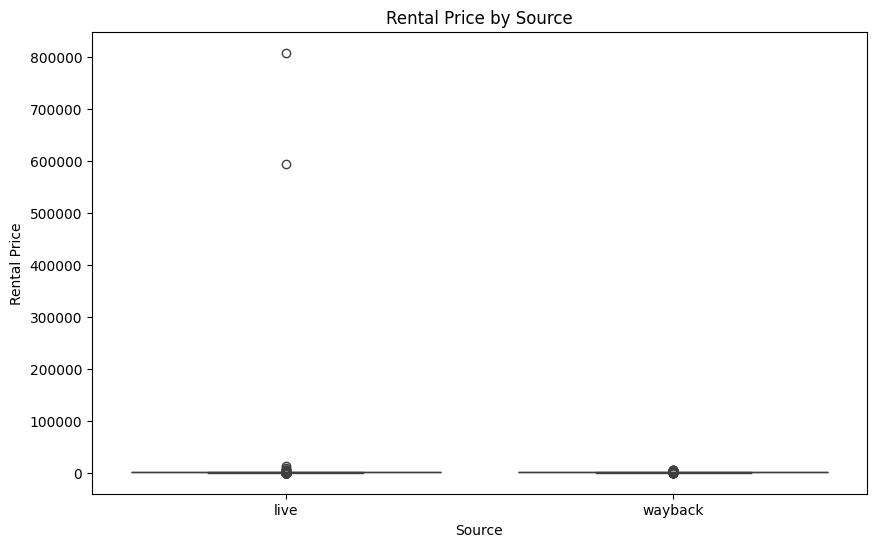

In [67]:
# Create a boxplot of the rental price and colour by source
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='rental_price', data=df_combined)
plt.title('Rental Price by Source')
plt.xlabel('Source')
plt.ylabel('Rental Price')
plt.show()

Text(0.5, 1.0, 'Rental Price by Source')

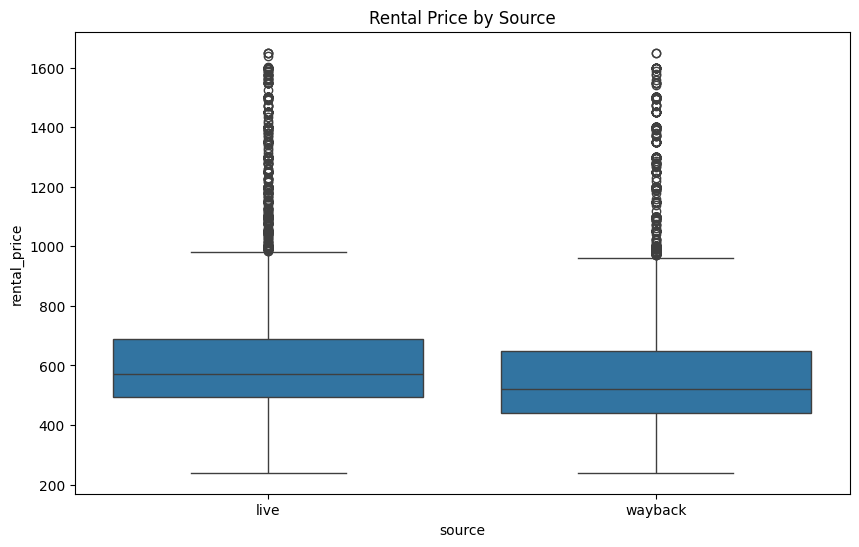

In [68]:
# Remove outliers based on 0.99 and 0.01 quantiles
df_combined = df_combined[df_combined['rental_price'] < df_combined['rental_price'].quantile(0.99)]
df_combined = df_combined[df_combined['rental_price'] > df_combined['rental_price'].quantile(0.01)]
# Create a boxplot of the rental price and colour by source
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='rental_price', data=df_combined)
plt.title('Rental Price by Source')

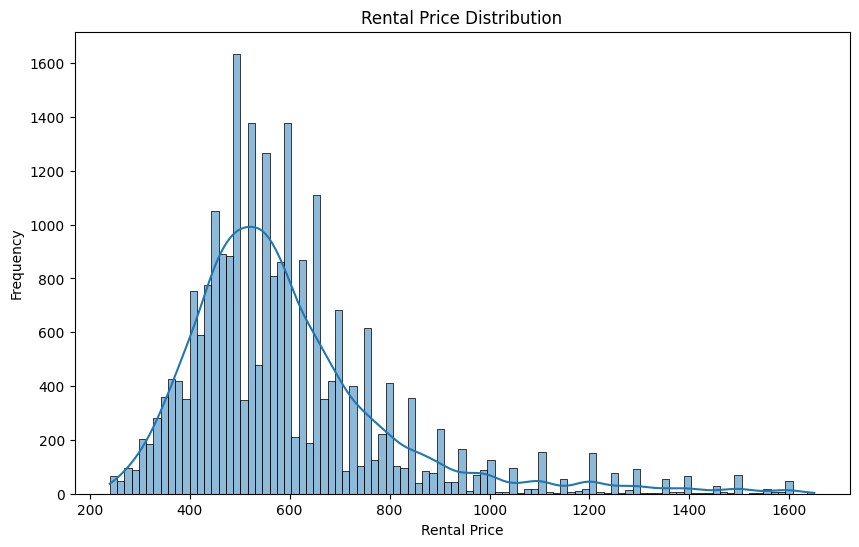

In [69]:
# Plot the histogram of the rental price and KDE plot
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['rental_price'], kde=True)
plt.title('Rental Price Distribution')
plt.xlabel('Rental Price')
plt.ylabel('Frequency')
plt.show()

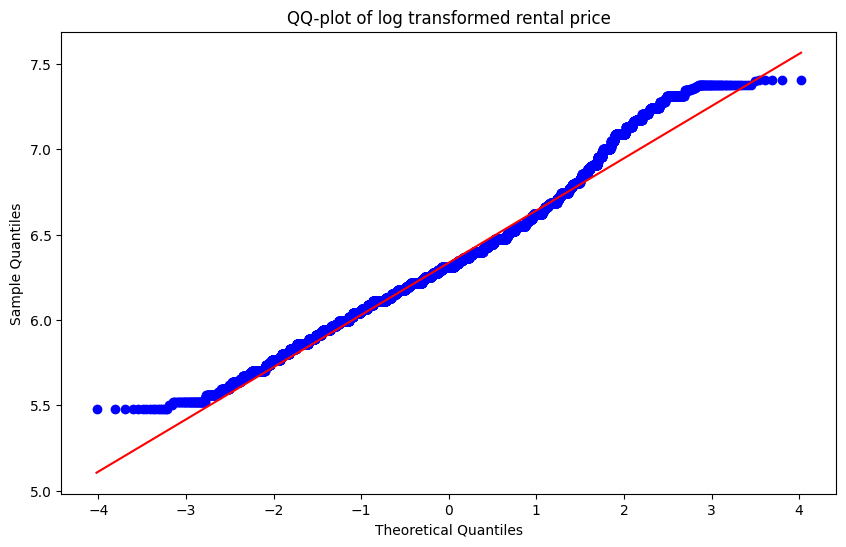

In [70]:
# Make a QQ-plot of the log transformed rental price
plt.figure(figsize=(10, 6))
stats.probplot(np.log(df_combined['rental_price']), dist="norm", plot=plt)
plt.title('QQ-plot of log transformed rental price')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [79]:
# Convert data types for df_combined
df_combined['property_id'] = df_combined['property_id'].astype('Int64')
df_combined['rental_price'] = df_combined['rental_price'].astype('Float64')
df_combined['suburb'] = df_combined['suburb'].astype('string')
df_combined['property_type'] = df_combined['property_type'].astype('string')
df_combined['year'] = df_combined['year'].astype('Int64')
df_combined['quarter'] = df_combined['quarter'].astype('Int64')
df_combined['source'] = df_combined['source'].astype('string')


In [80]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24027 entries, 0 to 4604
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       24027 non-null  Int64  
 1   property_id    24027 non-null  Int64  
 2   year           24027 non-null  Int64  
 3   coordinates    24027 non-null  object 
 4   source         24027 non-null  string 
 5   quarter        24027 non-null  Int64  
 6   bathrooms      24027 non-null  Int64  
 7   rental_price   24027 non-null  Float64
 8   suburb         24027 non-null  string 
 9   longitude      24027 non-null  float64
 10  car_spaces     24027 non-null  Int64  
 11  latitude       24027 non-null  float64
 12  property_type  24027 non-null  string 
dtypes: Float64(1), Int64(6), float64(2), object(1), string(3)
memory usage: 2.7+ MB


In [81]:
# Save the combined dataset
df_combined.to_csv("../data/processed/domain/cleaned_listings.csv", index=False)
print("✓ Saved combined dataset to data/processed/domain/cleaned_listings.csv")

# Display summary statistics
print(f"\nFinal combined dataset summary:")
print(f"Shape: {df_combined.shape}")
print(f"Date range: {df_combined['year'].min()}-{df_combined['quarter'].min()} to {df_combined['year'].max()}-{df_combined['quarter'].max()}")
print(f"Rental price range: ${df_combined['rental_price'].min():.0f} - ${df_combined['rental_price'].max():.0f}")
print(f"Mean rental price: ${df_combined['rental_price'].mean():.2f}")

# Show property type distribution
print(f"\nProperty type distribution:")
print(df_combined['property_type'].value_counts().head(10))


✓ Saved combined dataset to data/processed/domain/cleaned_listings.csv

Final combined dataset summary:
Shape: (24027, 13)
Date range: 2014-1 to 2025-4
Rental price range: $240 - $1650
Mean rental price: $593.53

Property type distribution:
property_type
house                            6115
House                            6086
apartment / unit / flat          4725
Apartment / Unit / Flat          4056
Townhouse                        1384
townhouse                        1208
studio                            192
Studio                             79
new apartments / off the plan      44
Villa                              37
Name: count, dtype: Int64


## 5. Subsampling the Dataset

In the interest of time, we subsample the dataset via stratified sampling by `suburb` and `property_type` in order to get a representative distribution of rent prices. This is because engineering the spatial features requires API calls that take a significant amount of time.

In [82]:
# Set random seed for reproducibility
import numpy as np
np.random.seed(42)

# First, shuffle the dataframe randomly
df_shuffled = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Create stratification groups based on property_type, suburb, and bedrooms
df_shuffled['strata'] = (
    df_shuffled['property_type'].astype(str) + '_' + 
    df_shuffled['suburb'].astype(str) + '_' + 
    df_shuffled['bedrooms'].astype(str)
)

# Perform stratified sampling to get 50% of the data
df_sampled = df_shuffled.groupby('strata', group_keys=False).apply(
    lambda x: x.sample(frac=0.5, random_state=42) if len(x) > 1 else x
)

# Drop the temporary strata column
df_sampled = df_sampled.drop(columns=['strata'])

# Reset index
df_sampled = df_sampled.reset_index(drop=True)

print(f"Original size: {len(df_shuffled):,} rows")
print(f"Sampled size: {len(df_sampled):,} rows")
print(f"Sampling ratio: {len(df_sampled) / len(df_shuffled):.1%}")

# Verify distribution is maintained
print("\n--- Property Type Distribution ---")
print("Original:")
print(df_shuffled['property_type'].value_counts(normalize=True).head())
print("\nSampled:")
print(df_sampled['property_type'].value_counts(normalize=True).head())

print("\n--- Bedrooms Distribution ---")
print("Original:")
print(df_shuffled['bedrooms'].value_counts(normalize=True).sort_index())
print("\nSampled:")
print(df_sampled['bedrooms'].value_counts(normalize=True).sort_index())


Original size: 24,027 rows
Sampled size: 12,823 rows
Sampling ratio: 53.4%

--- Property Type Distribution ---
Original:
property_type
house                      0.254505
House                      0.253298
apartment / unit / flat    0.196654
Apartment / Unit / Flat     0.16881
Townhouse                  0.057602
Name: proportion, dtype: Float64

Sampled:
property_type
House                      0.250331
house                      0.249318
apartment / unit / flat    0.191531
Apartment / Unit / Flat    0.167589
Townhouse                  0.061998
Name: proportion, dtype: Float64

--- Bedrooms Distribution ---
Original:
bedrooms
1     0.132351
2     0.293253
3     0.336205
4     0.217547
5      0.01798
6     0.001915
7     0.000333
8      0.00025
9     0.000125
50    0.000042
Name: proportion, dtype: Float64

Sampled:
bedrooms
1     0.133978
2     0.293769
3     0.329096
4     0.215082
5     0.023395
6     0.003353
7     0.000624
8      0.00039
9     0.000234
50    0.000078
Name: proport

/var/folders/xj/ny4zmnqd609bv2rpjzzr11rm0000gn/T/ipykernel_81261/1753491375.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_shuffled.groupby('strata', group_keys=False).apply(


In [73]:
# Save the subsampled dataset
df_sampled.to_csv("../data/processed/domain/cleaned_listings_sampled.csv", index=False)
print("✓ Saved subsampled dataset to data/processed/domain/cleaned_listings_sampled.csv")

✓ Saved subsampled dataset to data/processed/domain/cleaned_listings_sampled.csv


## 6. Summary

This notebook has successfully:

1. **Processed live listings** from Domain website with property feature parsing and imputation
2. **Processed wayback listings** from historical archives with address extraction and imputation
3. **Geocoded wayback addresses** using the Open Route Service API
4. **Combined both datasets** into a comprehensive rental listings dataset

### Output Files:
- `data/processed/domain/live_listings.csv` - Processed live listings
- `data/processed/domain/wayback_listings.csv` - Processed wayback listings  
- `data/processed/coordinates/geocoded_wayback_listings.csv` - Geocoded coordinates
- `data/processed/domain/cleaned_listings.csv` - Combined dataset

The combined dataset is now ready for **spatial feature engineering** (isochrones, POI, route distance, duration).
